In [40]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

In [41]:
def get_adp(year):

    url = f"https://www.fantasypros.com/nfl/adp/half-point-ppr-overall.php?year={year}"

    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    table = soup.find("table", id="data")

    rows = table.find_all("tr")

    data = []

    for row in rows:
        cells = row.find_all("td")
        if len(cells) > 0:
            rank = cells[0].text.strip()
            player = cells[1].text.strip()
            position = cells[2].text.strip()
            yahoo = cells[3].text.strip()
            sleeper = cells[4].text.strip()
            rtsports = cells[5].text.strip()   
            avg = cells[6].text.strip()
            
            data.append([rank, player, position, yahoo, sleeper, rtsports, avg])
            
    df = pd.DataFrame(data, columns=["Rank", "Player", "Position", "Yahoo", "Sleeper", "RTSports", "AVG"])
    df["Year"] = year
    return df

first_year = 2018
last_year = 2022

dfs = []
for year in range(first_year, last_year + 1):
    df = get_adp(year)
    dfs.append(df)
df = pd.concat(dfs)
df.to_csv(f"scrape/fp/adp_{first_year}_{last_year}.csv", index=False)

In [42]:
pos_col_dict = {
        'qb': ["Rank", "Player"
                , "CMP", "ATT", "PCT", "YDS", "Y/A", "TD", "INT", "SACKS"
                , "ATT", "YDS", "TD", "FL", "G", "FPTS", "FPTS/G"]
        , 'rb': ["Rank", "Player"
                , "rushing_ATT", "rushing_YDS", "rushing_Y/A", "rushing_LG", 'rushing_20+', 'rushing_TD'
                , 'receiving_REC', 'receiving_TGT', 'receiving_YDS', 'receiving_Y/R', 'receiving_TD'
                , 'misc_FL', 'misc_G', 'misc_FPTS', 'misc_FPTS/G']
        , 'wr': ["Rank", "Player"
                , 'receiving_REC', 'receiving_TGT', 'receiving_YDS', 'receiving_Y/R', 'receiving_LG', 'receiving_20+', 'receiving_TD'
                , "rushing_ATT", "rushing_YDS", "rushing_TD"
                # Not sure why rost is coming through for WR but didn't for the above two
                , 'misc_FL', 'misc_G', 'misc_FPTS', 'misc_FPTS/G', 'misc_ROST']
        , 'te': ["Rank", "Player"
                , 'receiving_REC', 'receiving_TGT', 'receiving_YDS', 'receiving_Y/R', 'receiving_LG', 'receiving_20+', 'receiving_TD'
                , "rushing_ATT", "rushing_YDS", "rushing_TD"
                # same as wr in regards to rost
                , 'misc_FL', 'misc_G', 'misc_FPTS', 'misc_FPTS/G', 'misc_ROST']
}

In [43]:
def get_historical(pos, year):

    url = f"https://www.fantasypros.com/nfl/stats/{pos}.php?year={year}&scoring=HALF"

    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    table = soup.find("table", id="data")

    rows = table.find_all("tr")

    data = []
    for row in rows:
        cells = row.find_all("td")
        if len(cells) > 1: 
            rank = cells[0].text.strip()
            player = cells[1].text.strip()
            passing_stats = [cell.text.strip() for cell in cells[2:10]]
            rushing_stats = [cell.text.strip() for cell in cells[10:13]]
            misc_stats = [cell.text.strip() for cell in cells[13:17]]
            stats = passing_stats + rushing_stats + misc_stats
            data.append([rank, player] + stats)
            
    columns = pos_col_dict[pos]

    df = pd.DataFrame(data, columns=columns)
    
    return df

In [44]:
first_year = 2018
last_year = 2022

for pos in pos_col_dict.keys():
        dfs = []
        for year in range(first_year, last_year + 1):
                df = get_historical(pos, year)
                df.to_csv(f"scrape/fp/{pos}_{year}.csv", index=False)
                dfs.append(df)
                df = pd.concat(dfs)       

dfs = []
for year in range(first_year, last_year+1):
    for pos in pos_col_dict.keys():
        df = pd.read_csv(f'scrape/fp/{pos}_{year}.csv')
        df['pos'] = pos
        df['year'] = year
        if pos != 'QB':
            df = df.rename(columns={'misc_FPTS': 'FPTS'})
        dfs.append(df)
df = pd.concat(dfs)
df = df[df['Player'].notna()]
df.to_csv(f'scrape/fp/player_performance_{first_year}_{last_year}.csv', index=False)

In [45]:
first_year = 2016
last_year = 2022
current_year = 2023

dfs = []
for year in range(first_year, last_year + 1):
    df = nfl.import_pbp_data([year])
    dfs.append(df)
df = pd.concat(dfs)
df.to_csv(f'scrape/nfl_data_py/df_pbp_{first_year}_{last_year}.csv', index=False)

df = nfl.import_pbp_data([current_year])
df.to_csv(f'scrape/nfl_data_py/df_pbp_{current_year}.csv', index=False)

2016 done.
Downcasting floats.
2017 done.
Downcasting floats.
2018 done.
Downcasting floats.
2019 done.
Downcasting floats.
2020 done.
Downcasting floats.
2021 done.
Downcasting floats.
2022 done.
Downcasting floats.
2023 done.
Downcasting floats.


In [47]:
def dynamic_window_ewma(x):
    """
    Calculate rolling exponentially weighted EPA with a dynamic window size
    """
    values = np.zeros(len(x))
    for i, (_, row) in enumerate(x.iterrows()):
        epa = x.epa_shifted[:i + 1]
        if row.week > 10:
            values[i] = epa.ewm(min_periods=1, span=row.week).mean().values[-1]
        else:
            values[i] = epa.ewm(min_periods=1, span=10).mean().values[-1]

    return pd.Series(values, index=x.index)

# data = pd.read_csv('df_pbp_2016_2021.csv')
# cy_data = pd.read_csv('df_pbp_2022.csv')
data = pd.read_csv(f'scrape/nfl_data_py/df_pbp_{first_year}_{last_year}.csv')
cy_data = pd.read_csv(f'scrape/nfl_data_py/df_pbp_{current_year}.csv')
data = data.append(cy_data, ignore_index=True)

home_game_dates = pd.DataFrame(data, columns=['home_team', 'week', 'season', 'game_date'])
home_game_dates.rename(columns={'home_team': 'team'}, inplace=True)
away_game_dates = pd.DataFrame(data, columns=['away_team', 'week', 'season', 'game_date'])
away_game_dates.rename(columns={'away_team': 'team'}, inplace=True)
game_dates = home_game_dates.append(away_game_dates)
game_dates.drop_duplicates(keep='first', inplace=True)

# seperate EPA in to rushing offense, rushing defense, passing offense, passing defense for each team
rushing_offense_epa = data.loc[data['rush_attempt'] == 1, :] \
    .groupby(['posteam', 'season', 'week'], as_index=False)['epa'].mean()

rushing_defense_epa = data.loc[data['rush_attempt'] == 1, :] \
    .groupby(['defteam', 'season', 'week'], as_index=False)['epa'].mean()

passing_offense_epa = data.loc[data['pass_attempt'] == 1, :] \
    .groupby(['posteam', 'season', 'week'], as_index=False)['epa'].mean()

passing_defense_epa = data.loc[data['pass_attempt'] == 1, :] \
    .groupby(['defteam', 'season', 'week'], as_index=False)['epa'].mean()

# lag EPA one period back
rushing_offense_epa['epa_shifted'] = rushing_offense_epa.groupby('posteam')['epa'].shift()
rushing_defense_epa['epa_shifted'] = rushing_defense_epa.groupby('defteam')['epa'].shift()
passing_offense_epa['epa_shifted'] = passing_offense_epa.groupby('posteam')['epa'].shift()
passing_defense_epa['epa_shifted'] = passing_defense_epa.groupby('defteam')['epa'].shift()

# In each case, calculate EWMA with a static window and dynamic window and assign it as a column
rushing_offense_epa['ewma'] = rushing_offense_epa.groupby('posteam')['epa_shifted'] \
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

rushing_offense_epa['ewma_dynamic_window'] = rushing_offense_epa.groupby('posteam') \
    .apply(dynamic_window_ewma).values

rushing_defense_epa['ewma'] = rushing_defense_epa.groupby('defteam')['epa_shifted'] \
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

rushing_defense_epa['ewma_dynamic_window'] = rushing_defense_epa.groupby('defteam') \
    .apply(dynamic_window_ewma).values

passing_offense_epa['ewma'] = passing_offense_epa.groupby('posteam')['epa_shifted'] \
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passing_offense_epa['ewma_dynamic_window'] = passing_offense_epa.groupby('posteam') \
    .apply(dynamic_window_ewma).values

passing_defense_epa['ewma'] = passing_defense_epa.groupby('defteam')['epa_shifted'] \
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passing_defense_epa['ewma_dynamic_window'] = passing_defense_epa.groupby('defteam') \
    .apply(dynamic_window_ewma).values

# Merge all the data together
offense_epa = rushing_offense_epa.merge(passing_offense_epa, on=['posteam', 'season', 'week'],
                                        suffixes=('_rushing', '_passing')) \
    .rename(columns={'posteam': 'team'})
defense_epa = rushing_defense_epa.merge(passing_defense_epa, on=['defteam', 'season', 'week'],
                                        suffixes=('_rushing', '_passing')) \
    .rename(columns={'defteam': 'team'})
epa = offense_epa.merge(defense_epa, on=['team', 'season', 'week'], suffixes=('_offense', '_defense'))

# # remove the first season of data
# epa = epa.loc[epa['season'] != epa['season'].unique()[0], :]

epa = epa.reset_index(drop=True)

epa = epa.merge(game_dates, on=['team', 'season', 'week'])

schedule = data[['season', 'week', 'home_team', 'away_team', 'home_score', 'away_score']] \
    .drop_duplicates().reset_index(drop=True) \
    .assign(home_team_win=lambda x: (x.home_score > x.away_score).astype(int))

epa_schedule_df = schedule.merge(epa.rename(columns={'team': 'home_team'}),
                                    on=['home_team', 'season', 'week']) \
    .merge(epa.rename(columns={'team': 'away_team'}), on=['away_team', 'season', 'week'],
            suffixes=('_home', '_away'))

epa_schedule_df['month'] = epa_schedule_df['game_date_home'].str.split('-').str[-3].astype(int)
epa_schedule_df['day'] = epa_schedule_df['game_date_home'].str.split('-').str[-2].astype(int)
epa_schedule_df['year'] = epa_schedule_df['game_date_home'].str.split('-').str[-1].astype(int)
epa_schedule_df = epa_schedule_df.dropna()

epa.to_csv('scrape/nfl_data_py/ewma_epa_df_2016_2022.csv')
schedule.to_csv('scrape/nfl_data_py/schedule_df_2016_2022.csv')
epa_schedule_df.to_csv('scrape/nfl_data_py/epa_schedule_df_2016_2022.csv')

C:\Users\grant\AppData\Local\Temp\ipykernel_2608\755331193.py:17: DtypeWarning: Columns (179,180,182,183,189,190,193,194,197,198,203,204,205,206,209,210,213,214,218,219,220,222,224,226,233,234,235,236,237,238,243,244,245,248,249,253,254,255,260,262,263,266,267,268,269,283,284,301) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f'scrape/nfl_data_py/df_pbp_{first_year}_{last_year}.csv')
C:\Users\grant\AppData\Local\Temp\ipykernel_2608\755331193.py:18: DtypeWarning: Columns (179,180,205,206,218,219,220,222,224,226,253,254,255,260,262,263) have mixed types. Specify dtype option on import or set low_memory=False.
  cy_data = pd.read_csv(f'scrape/nfl_data_py/df_pbp_{current_year}.csv')
C:\Users\grant\AppData\Local\Temp\ipykernel_2608\755331193.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(cy_data, ignore_index=True)
C:\Users\grant\

2022 done.
Downcasting floats.


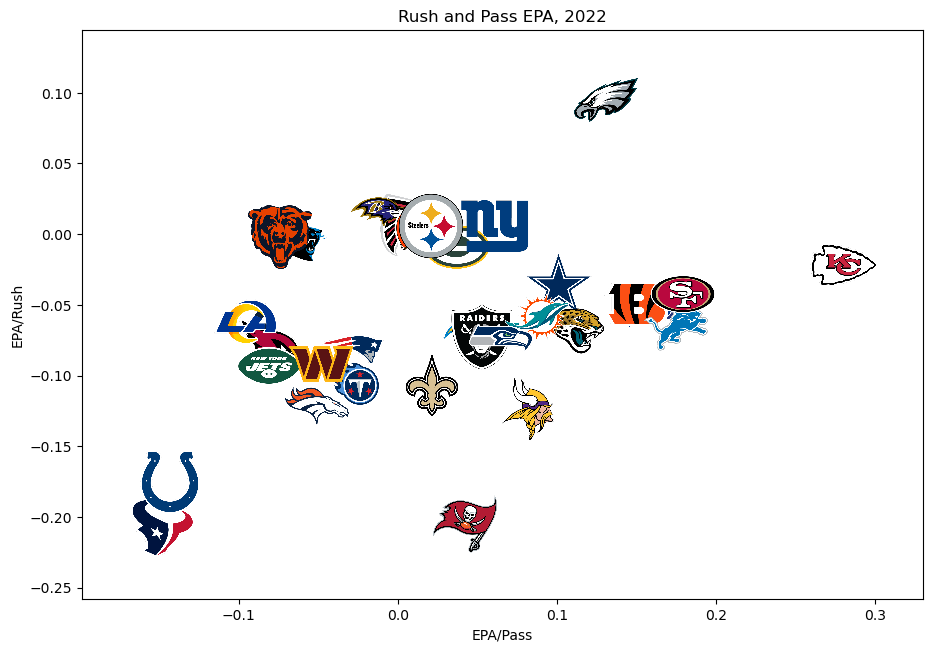

In [48]:
# https://github.com/tejseth/nfl-tutorials-2022/blob/master/nfl_data_py_1.ipynb

def chart_epa(year=2022):
    
    pbp = nfl.import_pbp_data([year])
    
    pbp_rp = pbp[(pbp['pass'] == 1) | (pbp['rush'] == 1)]
    pbp_rp = pbp_rp.dropna(subset=['epa', 'posteam', 'defteam'])
    
    pass_epa = pbp_rp[(pbp_rp['pass'] == 1)].groupby('posteam')['epa'].mean().reset_index().rename(columns = {'epa' : 'pass_epa'})
    rush_epa = pbp_rp[(pbp_rp['rush'] == 1)].groupby('posteam')['epa'].mean().reset_index().rename(columns = {'epa' : 'rush_epa'})
    epa = pd.merge(pass_epa, rush_epa, on = 'posteam')
    
    logos = nfl.import_team_desc()[['team_abbr', 'team_logo_espn']]
    
    logo_paths = []
    team_abbr = []
    if not os.path.exists("logos"):
        os.makedirs("logos")

    for team in range(len(logos)):
        urllib.request.urlretrieve(logos['team_logo_espn'][team], f"logos/{logos['team_abbr'][team]}.tif")
        logo_paths.append(f"logos/{logos['team_abbr'][team]}.tif")
        team_abbr.append(logos['team_abbr'][team])

    data = {'team_abbr' : team_abbr, 'logo_path' : logo_paths}
    logo_data = pd.DataFrame(data)

    epa_with_logos = pd.merge(epa, logo_data, left_on = 'posteam', right_on = 'team_abbr')
    
    plt.rcParams["figure.figsize"] = [10, 7]
    plt.rcParams["figure.autolayout"] = True

    def getImage(path):
        return OffsetImage(plt.imread(path, format="tif"), zoom=.1)

    x = epa_with_logos['pass_epa']
    y = epa_with_logos['rush_epa']
    paths = epa_with_logos['logo_path']

    fig, ax = plt.subplots()

    for x0, y0, path in zip(x, y, paths):
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

    xmin = min(x)
    xmax = max(x)
    ymin = min(y)
    ymax = max(y)

    buffer = 0.05
    plt.xlim(xmin-buffer, xmax+buffer)
    plt.ylim(ymin-buffer, ymax+buffer)

    plt.title(f"Rush and Pass EPA, {year}")
    plt.xlabel("EPA/Pass")
    plt.ylabel("EPA/Rush")
    plt.show()
    
chart_epa()

2023 done.
Downcasting floats.


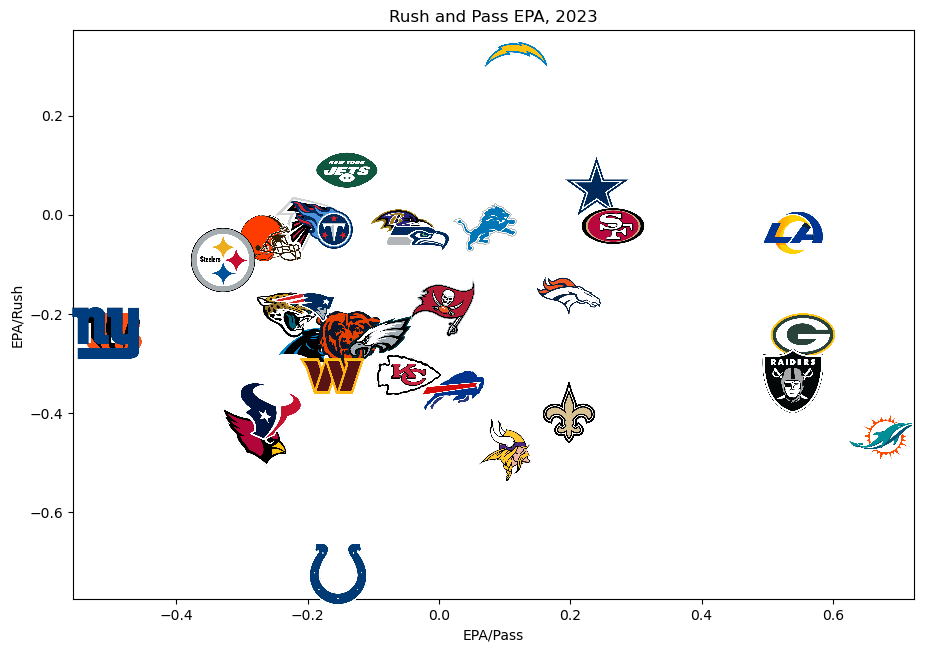

In [ ]:
chart_epa(2023)

In [49]:
pbp = nfl.import_pbp_data([2023])
pbp_rp = pbp[(pbp['pass'] == 1) | (pbp['rush'] == 1)]
pbp_rp = pbp_rp.dropna(subset=['epa', 'posteam', 'defteam'])

2023 done.
Downcasting floats.


In [50]:
# checked vs https://rbsdm.com/stats/stats/ and it tied

off_epa = pbp_rp.groupby('posteam')['epa'].mean().reset_index().rename(columns = {'epa' : 'all'})
off_pass_epa = pbp_rp[(pbp_rp['pass'] == 1)].groupby('posteam')['epa'].mean().reset_index().rename(columns = {'epa' : 'pass'})
off_epa = pd.merge(off_epa, off_pass_epa, on = 'posteam')
off_rush_epa = pbp_rp[(pbp_rp['rush'] == 1)].groupby('posteam')['epa'].mean().reset_index().rename(columns = {'epa' : 'rush'})
off_epa = pd.merge(off_epa, off_rush_epa, on = 'posteam').rename(columns = {'posteam' : 'team'})

def_epa = pbp_rp.groupby('defteam')['epa'].mean().reset_index().rename(columns = {'epa' : 'all'})
def_pass_epa = pbp_rp[(pbp_rp['pass'] == 1)].groupby('defteam')['epa'].mean().reset_index().rename(columns = {'epa' : 'pass'})
def_epa = pd.merge(def_epa, def_pass_epa, on = 'defteam')
def_rush_epa = pbp_rp[(pbp_rp['rush'] == 1)].groupby('defteam')['epa'].mean().reset_index().rename(columns = {'epa' : 'rush'})
def_epa = pd.merge(def_epa, def_rush_epa, on = 'defteam').rename(columns = {'defteam' : 'team'})

epa = pd.merge(off_epa, def_epa, on = 'team', suffixes=('_off', '_def'))
epa['net'] = epa['all_off'] - epa['all_def']

In [51]:
epa.sort_values('net', ascending = False).head()

,team,all_off,pass_off,rush_off,all_def,pass_def,rush_def,net
8,DAL,0.145421,0.239864,0.057274,-0.427093,-0.507376,-0.239767,0.572514
28,SF,0.127675,0.265352,-0.023324,-0.295510,-0.330006,-0.092361,0.423185
11,GB,0.155701,0.553851,-0.242449,-0.176294,-0.139230,-0.258479,0.331995
16,LA,0.253718,0.538440,-0.038121,-0.037636,-0.032568,-0.047473,0.291354
7,CLE,-0.145897,-0.255619,-0.047430,-0.411446,-0.497270,-0.239798,0.265548


In [52]:
epa.sort_values('net', ascending = True).head()

,team,all_off,pass_off,rush_off,all_def,pass_def,rush_def,net
23,NYG,-0.427093,-0.507376,-0.239767,0.145421,0.239864,0.057274,-0.572514
26,PIT,-0.295510,-0.330006,-0.092361,0.127675,0.265352,-0.023324,-0.423185
5,CHI,-0.176294,-0.139230,-0.258479,0.155701,0.553851,-0.242449,-0.331995
27,SEA,-0.037636,-0.032568,-0.047473,0.253718,0.538440,-0.038121,-0.291354
6,CIN,-0.411446,-0.497270,-0.239798,-0.145897,-0.255619,-0.047430,-0.265548


2022 done.
Downcasting floats.


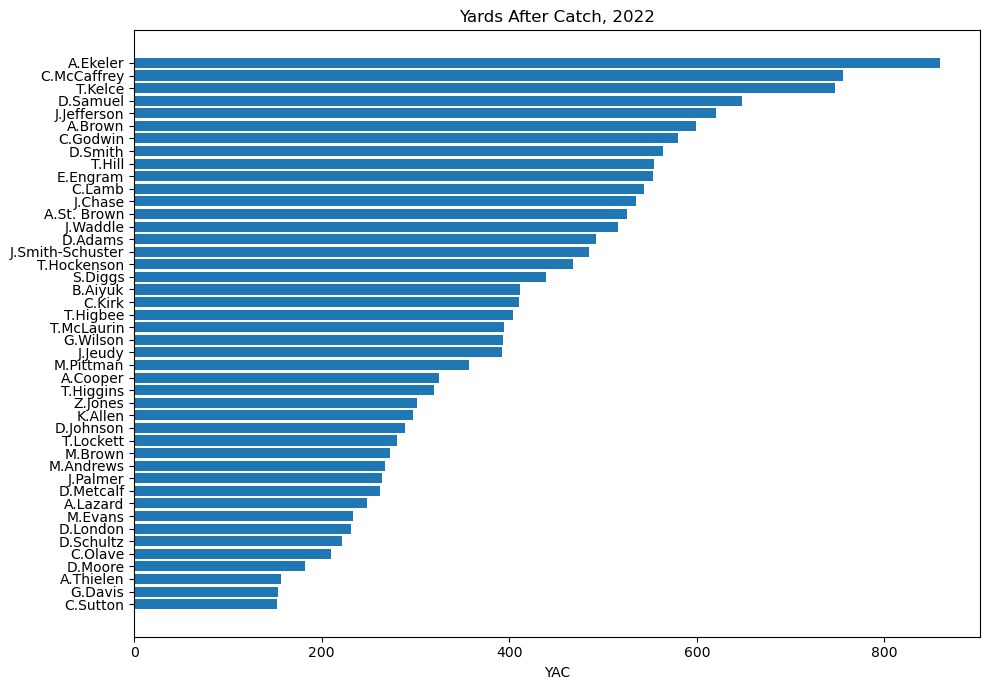

In [53]:
pbp = nfl.import_pbp_data([2022])
pbp_rp = pbp[(pbp['pass'] == 1) | (pbp['rush'] == 1)]
pbp_rp = pbp_rp.dropna(subset=['epa', 'posteam', 'defteam'])

receiver_yac = pbp_rp[(pbp_rp['pass'] == 1)].groupby('receiver_player_name').agg({'pass': 'count', 
        'yards_after_catch': 'sum'}).reset_index().rename(columns = {'pass' : 'targets', 'yards_after_catch' : 'yac'})
receiver_yac = receiver_yac[(receiver_yac['targets'] >= 100)]
receiver_yac.sort_values('yac', inplace = True)

name = receiver_yac['receiver_player_name']
yac = receiver_yac['yac']

fig, ax = plt.subplots(figsize=(10, 7))

ax.barh(name, yac)
ax.set_title("Yards After Catch, 2022")
ax.set_xlabel("YAC")
plt.show()

give these a look

https://towardsdatascience.com/analyzing-and-plotting-nfl-data-with-nflfastpy-and-plotly-a170a09cad6

https://opensourcefootball.com/